## Low-cost Singular Value Decomposition
Official implementation of the low-cost singular value decomposition algorithm. 

[Hetherington, Ashton, and Soledad Le Clainche. "Low-cost singular value decomposition with optimal sensor placement." *arXiv preprint* arXiv:2311.09791 (2023)](https://arxiv.org/abs/2311.09791)

**Description**

Low-cost singular value decomposition is a novel modal decomposition-based data assimilation method capable of optimally collecting experimental data and fusing it with numerical simulations, with the objective being to produce high resolution experimental datasets. 

In [ ]:
### Install the pysensors, hdf5storage and seaborn libraries
!pip install -q python-sensors seaborn mplcursors


[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
### Imports
import pysensors as ps
import numpy as np
import seaborn as sns
from scipy.io import loadmat
from mplcursors import cursor

import matplotlib.pyplot as plt

%matplotlib inline

# Configure the plot appearance
plt.rc('axes', labelsize = 18)
plt.rc('axes', titlesize = 18)
plt.rc('legend', fontsize = 22)
plt.rc('figure', titlesize = 24)
plt.rc('xtick', labelsize = 16)
plt.rc('ytick', labelsize = 16)

### Definition of the low-cost singular value decomposition function(s)

In [2]:
def optimalSensors(Tensor: np.ndarray, n_sensors: int):
  '''
  Finds the optimal sensors position using pysensors
  Args:
      - tensor (IxJ): snapshot matrix.
      - n_sensors: number of sensors to be used.
  Return:
      - sensors (1xn_sensors): vector of indexes for the optimal sensors.
  '''

  shape = Tensor.shape

  if Tensor.ndim == 3:
      Matrix = np.reshape(Tensor, (np.prod(shape[:-1]), shape[-1]))

      mesh_size = shape[:-1]

  else:
      norm = np.linalg.norm(Tensor.reshape(shape[0], np.prod(shape[1:])), axis=0)

      norm = np.reshape(norm, (1, *shape[1:]))

      Matrix = np.reshape(norm, (np.prod(shape[1:-1]), shape[-1]))

      mesh_size = shape[1:-1]

  X_train = np.transpose(Matrix, (1, 0))

  n_samples, n_features = X_train.shape

  print('Number of samples:', n_samples)
  print('Number of possible sensors:', n_features)

  model = ps.SSPOR(basis=ps.basis.SVD(n_basis_modes=2), n_sensors=n_sensors)

  model.fit(X_train)
  sensors = model.get_selected_sensors()

  sens = np.zeros(n_features)
  sens[sensors] = 1
  matrix = np.array(
      np.reshape(sens, mesh_size))

  x = []
  y = []
  z = []

  if len(shape) == 3:
      for i in range(shape[1]):
          for j in range(shape[0]):
              if matrix[j, i] == 1:
                  x.append(i)
                  y.append(j)

  elif len(shape) in [4, 5]:
      for i in range(shape[2]):
          for j in range(shape[1]):
              if matrix.ndim == 2:
                  if matrix[j, i] == 1:
                      x.append(i)
                      y.append(j)
              elif matrix.ndim == 3:
                  for k in range(shape[3]):
                      if matrix[j, i, k] == 1:
                          x.append(i)
                          y.append(j)
                          z.append(k)

  if matrix.shape == 2:
      z = None

  return sensors, x, y, z

def LCSVD(Ared: np.ndarray, tensor: np.ndarray, esvd: float, points: np.ndarray, time: list):
  """
  Low-cost singular value decomposition
  Args:
    - Ared: downsampled tensor
    - tensor: high-resolution tensor (ground truth)
    - esvd: singular value decomposition tolerance
    - points: array of points corresponding to the sensor positions
    - time: array of snapshot indexes

  Returns:
    - U: mxm matrix of the orthonormal eigenvectors of AA.T
    - S: diagonal matrix with r elements equal to the root of the positive eigenvalues of AA.T
    - V: transpose of a nxn matrix containing the orthonormal eigenvectors of A.TA
    - n_modes: number of modes retained during svd
    - TensorAprox: reconstructed tensor from low-resolution (Ared)
    - RRMSE: relative root mean squared error
  """

  shape = tensor.shape
  dims_prod = np.prod(shape[:-1])
  Tensor = np.reshape(tensor, (dims_prod, shape[-1]))

  Ured, S, Vred = np.linalg.svd(Ared, full_matrices = False)

  n_modes = 0
  norm = np.linalg.norm(S)
    
  for i in range(S.size):
      if np.linalg.norm(S[i:]) / norm <= esvd:
          pass
      else:
          n_modes += 1
            
  Sred = np.diag(S)
  Ured = Ured[:, :n_modes]
  Sred = Sred[:n_modes, :n_modes]
  Vred = Vred.conj().T
  Vred = Vred[:, :n_modes]

  Q, R = np.linalg.qr(Ured)
  Ured = Ured @ np.linalg.inv(R[:n_modes, :])
  Q1, R1 = np.linalg.qr(Vred)
  Vred = Vred @ np.linalg.inv(R1[:n_modes, :])

  ss = Ured.conj().T @ Ared @ Vred
  ss1 = np.sign(np.diag(np.diag(ss)))

  Vred = Vred @ ss1

  U = (Tensor[:, time] @ Vred) @ np.linalg.inv(Sred)
  V = (Tensor[points, :].conj().T @ Ured) @ np.linalg.inv(Sred)

  newshape = []
  newshape.append(shape[:-1])
  newshape.append(V.shape[0])
  newshape = list(newshape[0]) + [newshape[1]]

  TensorAprox = np.reshape((U @ Sred) @ V.conj().T, np.array(newshape))

  RRMSE = np.linalg.norm(np.reshape(tensor - TensorAprox, newshape=(np.size(tensor), 1)), ord=2) / np.linalg.norm(
      np.reshape(tensor, newshape=(np.size(tensor), 1)))

  return U, S[:n_modes], V, n_modes, TensorAprox, RRMSE

def sensorChecker(Tensor: np.ndarray, n_sensors: np.ndarray, esvd: float, tol: float) -> np.ndarray:
  '''
  Finds and verifies the optimal sensor positions based on an error threshold. This is used to calibrate the sensor positioning based on numerical data
  Args:
    - Tensor: high-resolution tensor used to find the optimal positions
    - n_sensors: number of sensors
    - esvd: singular value decomposition tolerance
    - tol: error tolerance threshold
  Returns:
    - sensors: optimal sensors vector
  '''

  RelativeErrorRMS = 1

  i = 1

  while RelativeErrorRMS * 100 > tol:

      print(f'Iteration number {i}')

      i += 1

      sensors, x, y, z = optimalSensors(Tensor[..., ::4], n_sensors)

      Ared = np.reshape(Tensor, (-1, Tensor.shape[-1]))

      Time = list(np.linspace(0, Tensor.shape[-1] - 1, Tensor.shape[-1]).astype(int))

      Ared = Ared[sensors, :]

      Ared = Ared[:, Time]

      _, _, _, _, _, RelativeErrorRMS = LCSVD(Ared = Ared, tensor = Tensor, esvd = esvd, points = sensors, time = Time)

  print(f'RRMSE - Reconstruction error for the optimal sensors combination: {(RelativeErrorRMS * 100):.3f}%\n')

  if Tensor.ndim == 3:
    fig, ax = plt.subplots(1, 1, figsize = (10, 4))
    plt.suptitle('Sensor positions')
    ax.contourf(Tensor[..., 0], alpha=0.5)
    ax.scatter(x, y, color='k')
    cursor(hover = True)
    plt.grid(color = 'grey')
    # ax.set_aspect('equal')
    plt.tight_layout()
    
  if Tensor.ndim == 4:
    comps = Tensor.shape[0]
    fig, ax = plt.subplots(1, comps, figsize = (12, 4), sharey = True)
    plt.suptitle('Sensor positions')
    for col in range(comps):
        ax[col].contourf(Tensor[col, ..., 0], alpha=0.5)
        ax[col].scatter(x, y, color = 'k')
        # ax[col].set_aspect('equal')
        ax[col].grid(color = 'grey')
    cursor(hover = True)
    plt.tight_layout()
      
  if Tensor.ndim == 5:
    comps = Tensor.shape[0]
    nz = int(Tensor.shape[3] / 2)
    fig, ax = plt.subplots(1, comps, figsize = (14, 4), sharey = True)
    plt.suptitle('Sensor positions in the XY plane')
    for col in range(comps):
        ax[col].contourf(Tensor[col, ..., nz, 0], alpha=0.5)
        ax[col].scatter(x, y, color = 'k')
        # ax[col].set_aspect('equal')
        ax[col].grid(color = 'grey')
    cursor(hover = True)
    plt.tight_layout()

  return sensors, x, y, z

### Data loading and visualization

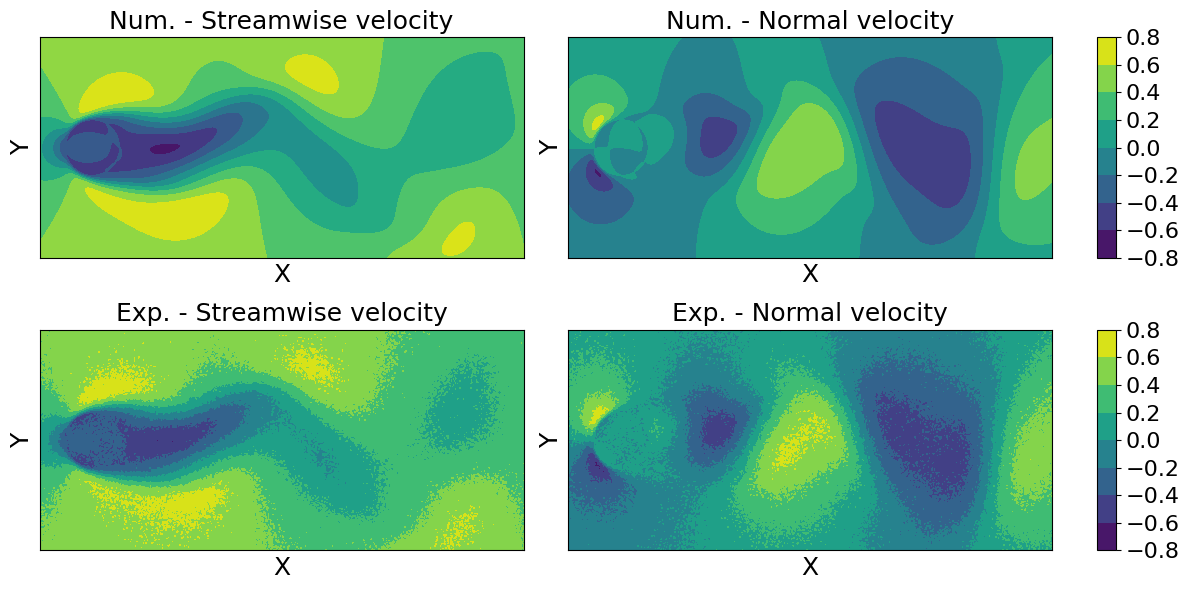

In [4]:
### Data is usually stored in .mat format
numericalTensor = list(loadmat('Tensor_cylinder_Re100.mat').values())[-1]

### Creating a synthetic experimental dataset
noise_level = 0.05  # Adjust noise magnitude
noise = np.random.normal(loc = 0, scale = noise_level, size = numericalTensor.shape)
syntheticExperimentalTensorHighRes = numericalTensor + noise

### Display both datasets
fig, ax = plt.subplots(2, 3, width_ratios = [25, 25, 1], figsize = (12, 6))

# Numerical dataset
ax[0, 0].contourf(numericalTensor[0, ..., 0])
ax[0, 0].set(title = 'Num. - Streamwise velocity', xlabel = 'X', ylabel = 'Y', xticks = [], yticks = [])
im1 = ax[0, 1].contourf(numericalTensor[1, ..., 0])
ax[0, 1].set(title = 'Num. - Normal velocity', xlabel = 'X', ylabel = 'Y', xticks = [], yticks = [])
plt.colorbar(im1, cax = ax[0, 2])

# Synthetic experimental dataset before final downsample
ax[1, 0].contourf(syntheticExperimentalTensorHighRes[0, ..., 0])
ax[1, 0].set(title = 'Exp. - Streamwise velocity', xlabel = 'X', ylabel = 'Y', xticks = [], yticks = [])
im3 = ax[1, 1].contourf(syntheticExperimentalTensorHighRes[1, ..., 0])
ax[1, 1].set(title = 'Exp. - Normal velocity', xlabel = 'X', ylabel = 'Y', xticks = [], yticks = [])
plt.colorbar(im3, cax = ax[1, 2])
plt.tight_layout()

### Optimal selection of experimental data points
Data can be sampled optimally, using pysensors (`optimal = True`), or equidistantly (`optimal = False`), using matrix slicing.

Here:
* `n_sensors`: number of sensors or samples of data to collect
* `esvd` (`optimal = True`): singular value decomposition mode retention tolerance
* `tol` (`optimal = True`): reconstruction error (RRMSE) threshold

Searching for optimal sensor positions...

Iteration number 1
Number of samples: 38
Number of possible sensors: 89351
RRMSE - Reconstruction error for the optimal sensors combination: 0.270%



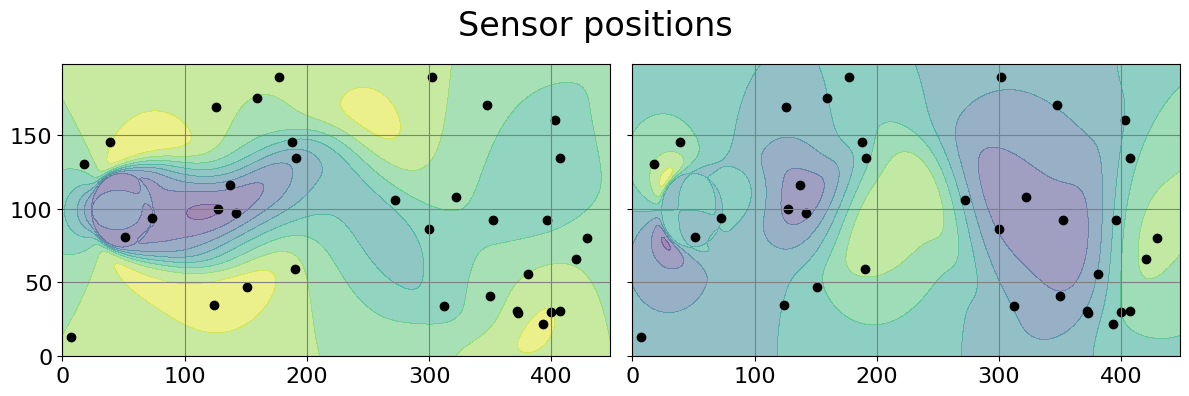

In [31]:
### Default option: optimal sensor placement
optimal = True
n_sensors = 35 # Number of sensors

if optimal:
    print('Searching for optimal sensor positions...\n')

    esvd = 1e-03 # svd tolerance for mode retention
    tol = 0.5 # Reconstruction RRMSE tolerance threshold

    one_sensors, x, y, z = sensorChecker(Tensor = numericalTensor, n_sensors = n_sensors, esvd = esvd, tol = tol)
    
    if numericalTensor.ndim == 3:
        sensors = one_sensors
            
    else:
        last_value = np.prod(numericalTensor.shape[1:-1])

        sorted_sensors = sorted(one_sensors)

        sensors = sorted_sensors + [x + last_value for x in sorted_sensors]

else:
    print('Downsampling dataset equidistantly...\n')

    n_sensors *= 2

    tenShape = numericalTensor.shape

    sensors = np.linspace(0, np.prod(tenShape[1:-1]) - 1, n_sensors).astype(int)

Time = list(np.linspace(0, numericalTensor.shape[-1] - 1, numericalTensor.shape[-1]).astype(int))

### Experimental data collection
The optimal sensors are used to measure the experimental data, which is collected as follows:

Downsampled tensor shape: (70, 151)


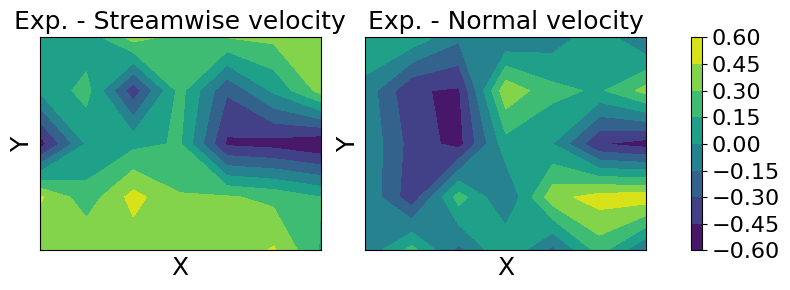

In [52]:
syntheticExperimentalTensor = np.reshape(syntheticExperimentalTensorHighRes, (-1, syntheticExperimentalTensorHighRes.shape[-1]))

syntheticExperimentalTensor = syntheticExperimentalTensor[sensors, :]

syntheticExperimentalTensor = syntheticExperimentalTensor[:, Time]

print(f'Downsampled tensor shape: {syntheticExperimentalTensor.shape}')

nv, nx, ny, nt = numericalTensor.shape

syntheticExperimental = syntheticExperimentalTensor.reshape(nv, int(n_sensors ** 0.5), n_sensors - (int(n_sensors ** 0.5 + 1) ** 2), nt)

# Synthetic experimental dataset before final downsample
fig, ax = plt.subplots(1, 3, width_ratios = [25, 25, 1], figsize = (8, 3))
ax[0].contourf(syntheticExperimental[0, ..., 0])
ax[0].set(title = 'Exp. - Streamwise velocity', xlabel = 'X', ylabel = 'Y', xticks = [], yticks = [])
im3 = ax[1].contourf(syntheticExperimental[1, ..., 0])
ax[1].set(title = 'Exp. - Normal velocity', xlabel = 'X', ylabel = 'Y', xticks = [], yticks = [])
plt.colorbar(im3, cax = ax[2])
plt.tight_layout()

**Note:** Experimental data is collected in an array and the previous plot is an approximate example

### Reconstruction and up-scaling of the experimental data using low-cost singular value decomposition (LC-SVD)
Given a high resolution numerical dataset (`numericalTensor`), a low resolution experimental dataset (`syntheticExperimentalTensor`), an array of sensor coordinates (`sensors`) and temporal spacing (`Time`), we can use low-cost singular value decomposition to reconstruct the experimental tensor via data assimilation.

Applying the `LCSVD` funtion returns the reconstructed POD modes, singular values and temporal coefficients, the number of svd modes used for the reconstruction (retained modes), the reconstructed tensor, and the reconstruction RRMSE.

In [53]:
U, S, V, n_modes, experimentalReconstructed, RRMSE = \
LCSVD(Ared = syntheticExperimentalTensor, tensor = numericalTensor, esvd = esvd, points = sensors, time = Time)

In [56]:
print(f'''
Reconstructed POD modes tensor shape: {U.reshape(nv, nx, ny, -1).shape}
Reconstructed singular values matrix shape: {np.diag(S).shape}
Reconstructed temporal coefficients matrix shape: {V.T.shape}
Reconstructed experimental tensor shape: {experimentalReconstructed.shape}
Reconstruction RRMSE: {RRMSE:.3f} %
''')


Reconstructed POD modes tensor shape: (2, 199, 449, 70)
Reconstructed singular values matrix shape: (70, 70)
Reconstructed temporal coefficients matrix shape: (70, 151)
Reconstructed experimental tensor shape: (2, 199, 449, 151)
Reconstruction RRMSE: 0.013 %



### Results plotting and error analysis
Contour maps are used to analyse the reconstruction error pixel-wise.

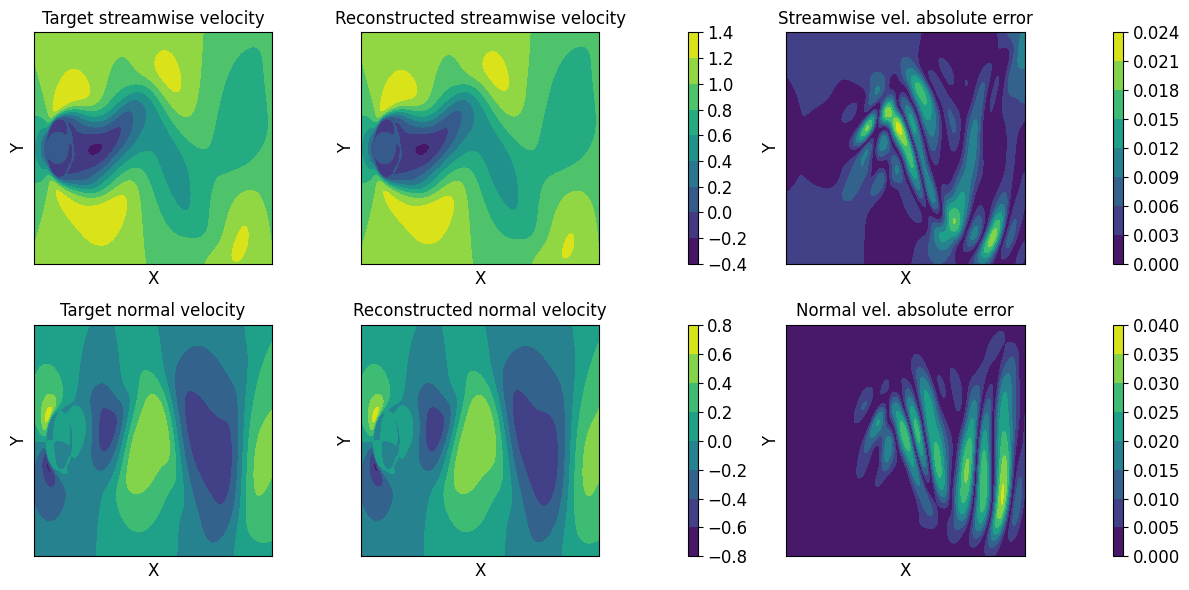

In [62]:
plt.rc('axes', labelsize = 12)
plt.rc('axes', titlesize = 12)
plt.rc('legend', fontsize = 12)
plt.rc('figure', titlesize = 12)
plt.rc('xtick', labelsize = 12)
plt.rc('ytick', labelsize = 12)

fig, ax = plt.subplots(2, 5, width_ratios = [25, 25, 1, 25, 1], figsize = (12, 6))
# Streamwise velocity
ax[0, 0].contourf(numericalTensor[0, ..., 0])
ax[0, 0].set(title = 'Target streamwise velocity', xlabel = 'X', ylabel = 'Y', xticks = [], yticks = [])
im1 = ax[0, 1].contourf(experimentalReconstructed[0, ..., 0])
ax[0, 1].set(title = 'Reconstructed streamwise velocity', xlabel = 'X', ylabel = 'Y', xticks = [], yticks = [])
plt.colorbar(im1, cax = ax[0, 2])
im2 = ax[0, 3].contourf(np.abs(numericalTensor[0, ..., 0] - experimentalReconstructed[0, ..., 0]))
ax[0, 3].set(title = 'Streamwise vel. absolute error', xlabel = 'X', ylabel = 'Y', xticks = [], yticks = [])
plt.colorbar(im2, cax = ax[0, 4])

# Normal velocity
ax[1, 0].contourf(numericalTensor[1, ..., 0])
ax[1, 0].set(title = 'Target normal velocity', xlabel = 'X', ylabel = 'Y', xticks = [], yticks = [])
im3 = ax[1, 1].contourf(experimentalReconstructed[1, ..., 0])
ax[1, 1].set(title = 'Reconstructed normal velocity', xlabel = 'X', ylabel = 'Y', xticks = [], yticks = [])
plt.colorbar(im3, cax = ax[1, 2])
im4 = ax[1, 3].contourf(np.abs(numericalTensor[1, ..., 0] - experimentalReconstructed[1, ..., 0]))
ax[1, 3].set(title = 'Normal vel. absolute error', xlabel = 'X', ylabel = 'Y', xticks = [], yticks = [])
plt.colorbar(im4, cax = ax[1, 4])
plt.tight_layout()

### Uncertainty quantification
In this case, uncertainty quantification is applied to assess the probability distributions of reconstruction errors for both velocity components. Essentially, it evaluates the likelihood of obtaining high or low reconstruction errors. The objective is for LCSVD to produce reconstruction results that manifest as a narrow vertical line centered at zero for both velocity components. This would indicate a high level of certainty that, for any randomly selected point in the velocity field, the reconstruction error will be zero.

The reconstruction error for a given velocity components is computed as:

$$
\epsilon_i = \frac{target_i - reconstructed_i}{max(| target_i - reconstructed_ i |)}
$$

where $i$ is the given velocity component, which can be streamwise, normal or spanwise, in the case of 3D velocity fields.

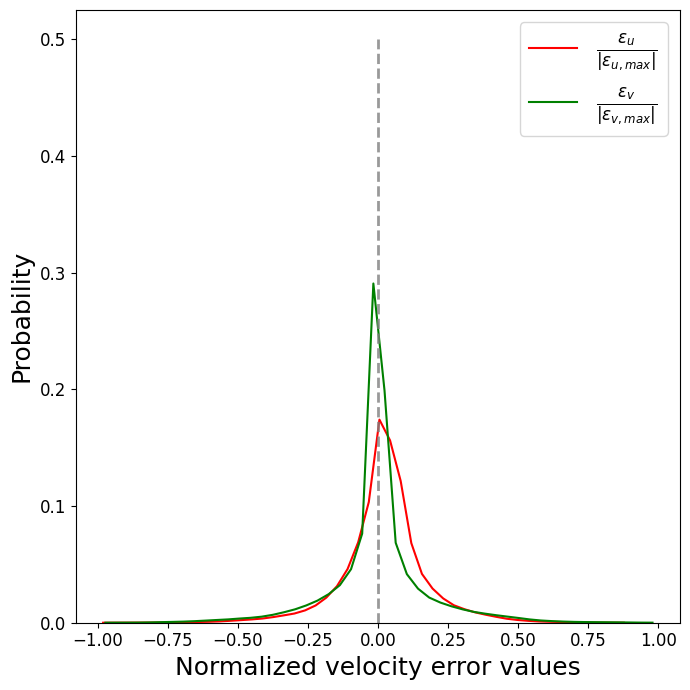

In [70]:
epsU = (numericalTensor[0, ...] - experimentalReconstructed[0, ...]) / np.abs(numericalTensor[0, ...] - experimentalReconstructed[0, ...]).max()
epsV = (numericalTensor[1, ...] - experimentalReconstructed[1, ...]) / np.abs(numericalTensor[1, ...] - experimentalReconstructed[1, ...]).max()

if experimentalReconstructed.ndim == 5:
    epsW = (numericalTensor[2, ...] - experimentalReconstructed[2, ...]) / np.abs(numericalTensor[2, ...] - experimentalReconstructed[2, ...]).max()

# Plot probability distribution functions
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.histplot(data=epsU.flatten(), stat='probability', bins=50, legend=True, ax=ax,
             label=r'$\frac{\epsilon_u}{|\epsilon_{u, max}|}$', kde=False, fill=False,
             common_norm=False, element='poly', color="red")

if experimentalReconstructed.ndim > 3:
    if experimentalReconstructed.shape[0] >= 2:
        sns.histplot(data=epsV.flatten(), stat='probability', bins=50, legend=True, ax=ax,
                     label=r'$\frac{\epsilon_v}{|\epsilon_{v, max}|}$', kde=False, fill=False,
                     common_norm=False, element='poly', color="green")

        if experimentalReconstructed.shape[0] == 3:
            sns.histplot(data=epsW.flatten(), stat='probability', bins=50, legend=True, ax=ax,
                         label=r'$\frac{\epsilon_w}{|\epsilon_{w, max}|}$', kde=False, fill=False,
                         common_norm=False, element='poly', color="blue")

    ax.legend(loc='best', fontsize = 'xx-large')

    ax.set(xlabel = None, ylabel = None)

ax.set_xlabel('Normalized velocity error values', fontsize = 18)
ax.set_ylabel('Probability', fontsize = 18)

ax.vlines(0, ymin=0, ymax=0.5, colors="gray", alpha=0.8, lw=2, linestyles="dashed")
plt.tight_layout()